Exploratory Data Analysis


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
df = pd.read_parquet('../data/Bronze/HI_Medium_cleaned.parquet')

Temporal Features

In [4]:
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['date'] = df['Timestamp'].dt.date
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_night'] = df['hour'].isin(range(0, 6)).astype(int)

print(f"Weekend transactions: {df['is_weekend'].sum():,}")
print(f"Night transactions: {df['is_night'].sum():,}")

Weekend transactions: 3,325,397
Night transactions: 9,570,874


 Chi-Square Independence Tests



- Null Hypothesis (H₀): There is no association between the categorical variables.
- Alternative Hypothesis (H₁): There is an association between the categorical variables.

In [6]:

categorical_features = ['Payment Format', 'Receiving Currency', 'Payment Currency']

chi_results = []
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['Is Laundering'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    chi_results.append({
        'Feature': feature,
        'Chi2': chi2,
        'p-value': p_value,
        'DOF': dof,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })
    
    print(f"{feature}:")
    print(f"  Chi2 = {chi2:.2f}")
    print(f"  p-value = {p_value:.2e}")
    print(f"  Result: {'REJECT H0 - Feature is significant' if p_value < 0.05 else 'FAIL TO REJECT H0'}\n")

chi_df = pd.DataFrame(chi_results)
display(chi_df)

Payment Format:
  Chi2 = 186990.17
  p-value = 0.00e+00
  Result: REJECT H0 - Feature is significant

Receiving Currency:
  Chi2 = 3471.32
  p-value = 0.00e+00
  Result: REJECT H0 - Feature is significant

Payment Currency:
  Chi2 = 3380.34
  p-value = 0.00e+00
  Result: REJECT H0 - Feature is significant



,Feature,Chi2,p-value,DOF,Significant
0,Payment Format,186990.1700,0.0000,6,Yes
1,Receiving Currency,3471.3179,0.0000,14,Yes
2,Payment Currency,3380.3441,0.0000,14,Yes


So we are keeping all of categorical columns since p value is <0.05 (We fail to reject null ).

Variance Inflation Factor for numerical features

In [9]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

numerical_features = ['From Bank', 'To Bank', 'Amount Received', 'Amount Paid', 'hour', 'day_of_week']

X_vif = df[numerical_features].copy()

vif_data = pd.DataFrame()
vif_data['Feature'] = numerical_features
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(len(numerical_features))]
vif_data = vif_data.sort_values('VIF', ascending=False)


print("VIF Interpretation:")
print("  VIF = 1: No correlation")
print("  VIF < 5: Low correlation (acceptable)")
print("  VIF 5-10: Moderate correlation (caution)")
print("  VIF > 10: High correlation (multicollinearity issue)\n")

VIF Interpretation:
  VIF = 1: No correlation
  VIF < 5: Low correlation (acceptable)
  VIF 5-10: Moderate correlation (caution)
  VIF > 10: High correlation (multicollinearity issue)



In [10]:

display(vif_data)

high_vif = vif_data[vif_data['VIF'] > 5]
if len(high_vif) > 0:
    print(f"\nWarning: {len(high_vif)} features with VIF > 5:")
    for idx, row in high_vif.iterrows():
        print(f"  {row['Feature']}: VIF = {row['VIF']:.2f}")
else:
    print("\nNo multicollinearity detected (all VIF < 5)")

,Feature,VIF
3,Amount Paid,2.0848
2,Amount Received,2.0848
0,From Bank,1.1390
1,To Bank,1.1021
4,hour,0.6622
5,day_of_week,0.5472



No multicollinearity detected (all VIF < 5)


Exploratory Analysis 

 Laundering Rate by Payment Format

In [11]:
payment_analysis = df.groupby('Payment Format').agg({
    'Is Laundering': ['sum', 'count', 'mean']
}).round(4)

payment_analysis.columns = ['Laundering_Count', 'Total_Txns', 'Laundering_Rate']
payment_analysis['Laundering_Rate_Pct'] = payment_analysis['Laundering_Rate'] * 100
payment_analysis['Risk_Multiplier'] = payment_analysis['Laundering_Rate'] / df['Is Laundering'].mean()
payment_analysis = payment_analysis.sort_values('Laundering_Rate_Pct', ascending=False)

print("Laundering Rate by Payment Format")
payment_analysis

Laundering Rate by Payment Format


,Laundering_Count,Total_Txns,Laundering_Rate,Laundering_Rate_Pct,Risk_Multiplier
Payment Format,,,,,
ACH,30746,3868404,0.0079,0.7900,7.1529
Bitcoin,244,689025,0.0004,0.0400,0.3622
Cash,666,3217531,0.0002,0.0200,0.1811
Cheque,2220,12280058,0.0002,0.0200,0.1811
Credit Card,1354,8777816,0.0002,0.0200,0.1811
Reinvestment,0,1945611,0.0000,0.0000,0.0000
Wire,0,1119773,0.0000,0.0000,0.0000


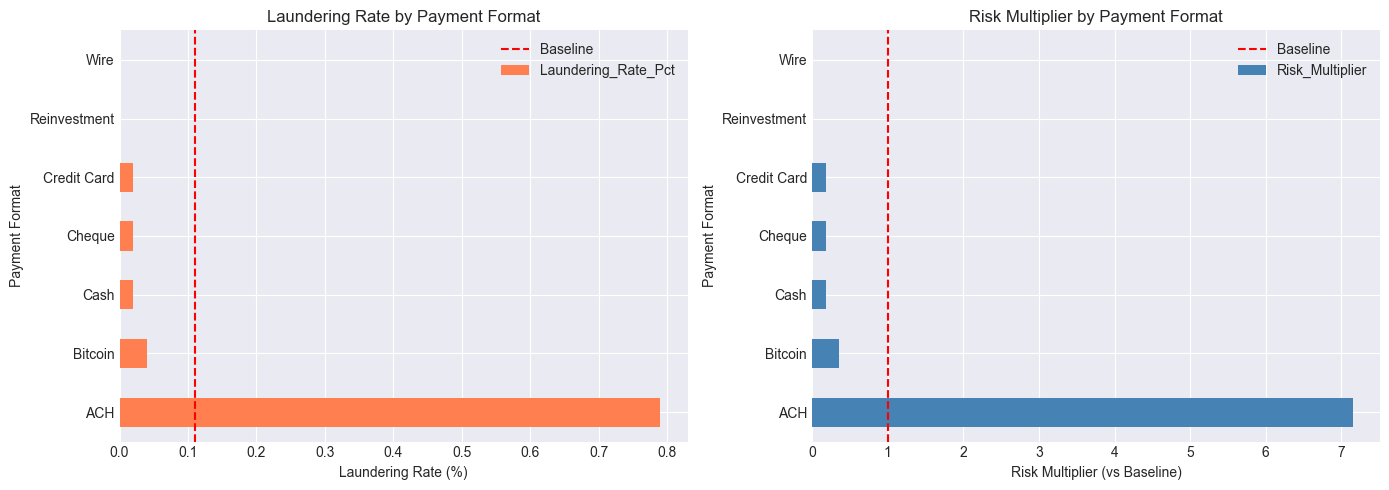

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

payment_analysis['Laundering_Rate_Pct'].plot(kind='barh', ax=ax[0], color='coral')
ax[0].set_xlabel('Laundering Rate (%)')
ax[0].set_title('Laundering Rate by Payment Format')
ax[0].axvline(df['Is Laundering'].mean()*100, color='red', linestyle='--', label='Baseline')
ax[0].legend()

payment_analysis['Risk_Multiplier'].plot(kind='barh', ax=ax[1], color='steelblue')
ax[1].set_xlabel('Risk Multiplier (vs Baseline)')
ax[1].set_title('Risk Multiplier by Payment Format')
ax[1].axvline(1.0, color='red', linestyle='--', label='Baseline')
ax[1].legend()

plt.tight_layout()
plt.show()

Cross-Currency Transaction Analysis

In [13]:
df['is_cross_currency'] = (df['Receiving Currency'] != df['Payment Currency']).astype(int)

cross_currency_analysis = df.groupby('is_cross_currency').agg({
    'Is Laundering': ['sum', 'count', 'mean']
}).round(4)

In [ ]:

cross_currency_analysis.columns = ['Laundering_Count', 'Total_Txns', 'Laundering_Rate']
cross_currency_analysis.index = ['Same Currency', 'Cross Currency']
cross_currency_analysis['Laundering_Rate_Pct'] = cross_currency_analysis['Laundering_Rate'] * 100


In [ ]:
cross_currency_analysis

,Laundering_Count,Total_Txns,Laundering_Rate,Laundering_Rate_Pct
Same Currency,35230,31413081,0.0011,0.1100
Cross Currency,0,485137,0.0000,0.0000


Zero laundering cases in cross-currency transactions

Temporal Pattern Analysis

In [21]:
# Hourly analysis
hourly_analysis = df.groupby('hour').agg({
    'Is Laundering': ['sum', 'count', 'mean']
})

hourly_analysis.columns = ['Laundering_Count', 'Total_Txns', 'Laundering_Rate']
hourly_analysis['Laundering_Rate_Pct'] = hourly_analysis['Laundering_Rate'] * 100
hourly_analysis.to_string(float_format=lambda x: f'{x:.6f}')
hourly_analysis


,Laundering_Count,Total_Txns,Laundering_Rate,Laundering_Rate_Pct
hour,,,,
0,1102,3372880,0.0003,0.0327
1,1025,1238051,0.0008,0.0828
2,1071,1237519,0.0009,0.0865
3,993,1240535,0.0008,0.0800
4,1029,1241507,0.0008,0.0829
5,1308,1240382,0.0011,0.1055
6,1308,1238863,0.0011,0.1056
7,1318,1241455,0.0011,0.1062
8,1616,1238733,0.0013,0.1305


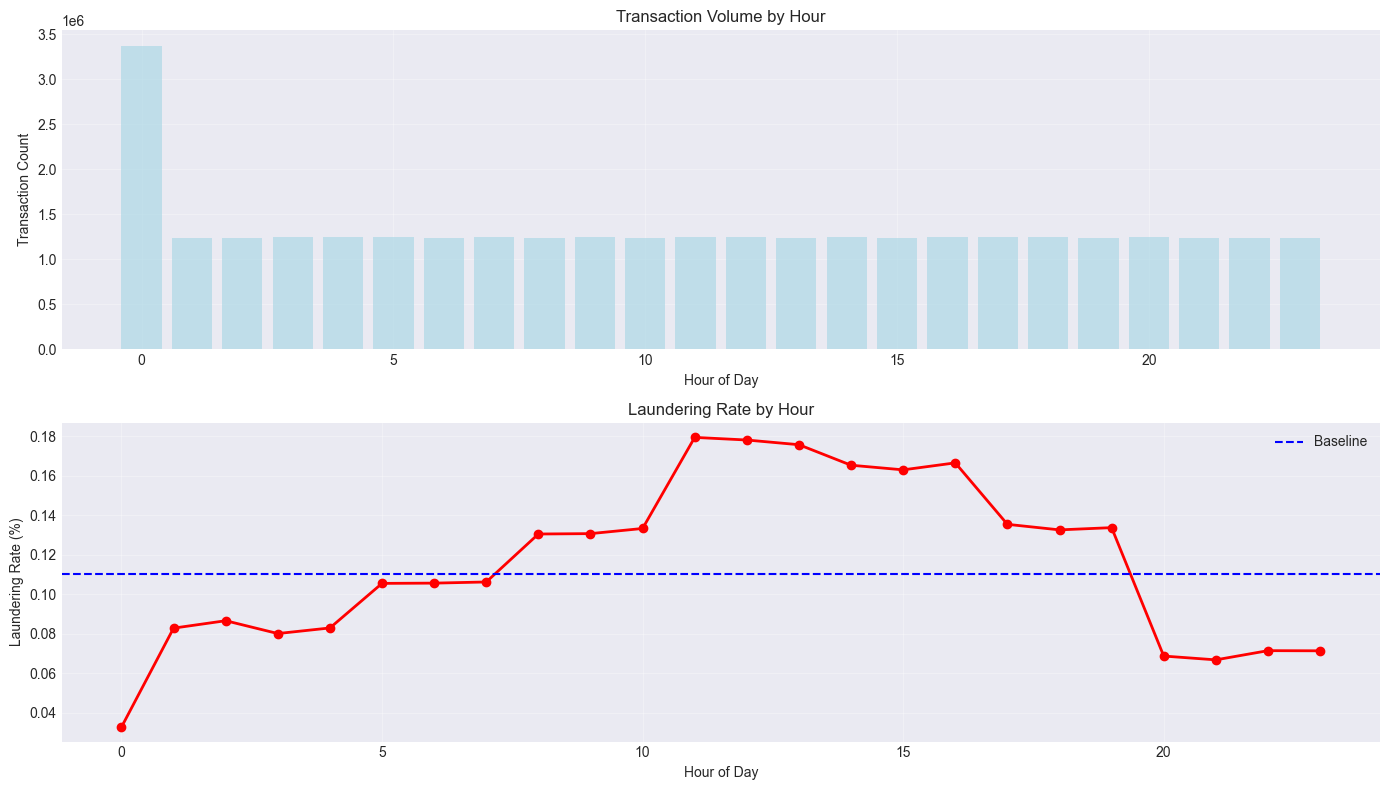

In [22]:
# Visualization
fig, ax = plt.subplots(2, 1, figsize=(14, 8))

ax[0].bar(hourly_analysis.index, hourly_analysis['Total_Txns'], color='lightblue', alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Transaction Count')
ax[0].set_title('Transaction Volume by Hour')
ax[0].grid(True, alpha=0.3)

ax[1].plot(hourly_analysis.index, hourly_analysis['Laundering_Rate_Pct'], marker='o', color='red', linewidth=2)
ax[1].axhline(df['Is Laundering'].mean()*100, color='blue', linestyle='--', label='Baseline')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Laundering Rate (%)')
ax[1].set_title('Laundering Rate by Hour')
ax[1].legend()
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [23]:

print(f"Night-time (00:00-06:00) laundering rate: {df[df['is_night']==1]['Is Laundering'].mean()*100:.2f}%")
print(f"Day-time (06:00-24:00) laundering rate: {df[df['is_night']==0]['Is Laundering'].mean()*100:.2f}%")

Night-time (00:00-06:00) laundering rate: 0.07%
Day-time (06:00-24:00) laundering rate: 0.13%


Day of Week Analysis

In [24]:
dow_analysis = df.groupby('day_of_week').agg({
    'Is Laundering': ['sum', 'count', 'mean']
}).round(4)

dow_analysis.columns = ['Laundering_Count', 'Total_Txns', 'Laundering_Rate']
dow_analysis['Laundering_Rate_Pct'] = dow_analysis['Laundering_Rate'] * 100
dow_analysis.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_analysis

,Laundering_Count,Total_Txns,Laundering_Rate,Laundering_Rate_Pct
Monday,4774,3860091,0.0012,0.1200
Tuesday,4822,3858594,0.0012,0.1200
Wednesday,4749,3862560,0.0012,0.1200
Thursday,5647,8327319,0.0007,0.0700
Friday,6030,8664257,0.0007,0.0700
Saturday,4718,1662955,0.0028,0.2800
Sunday,4490,1662442,0.0027,0.2700


In [25]:
print(f"\nWeekend laundering rate: {df[df['is_weekend']==1]['Is Laundering'].mean()*100:.4f}%")
print(f"Weekday laundering rate: {df[df['is_weekend']==0]['Is Laundering'].mean()*100:.4f}%")


Weekend laundering rate: 0.2769%
Weekday laundering rate: 0.0911%


 Amount Distribution Analysis

In [30]:
normal_transactions= df[df['Is Laundering']==0]['Amount Paid'].describe()
laundering_transactions = df[df['Is Laundering']==1]['Amount Paid'].describe()


In [31]:
normal_transactions

count        31862988.0000
mean          4363706.0000
std        1841879424.0000
min                 0.0000
25%               208.8300
50%              1467.3600
75%             11736.1104
max     8158609145856.0000
Name: Amount Paid, dtype: float64

In [32]:
laundering_transactions

count          35230.0000
mean        53116740.0000
std       4988977664.0000
min                0.0000
25%             2991.9274
50%             8668.9648
75%            17424.5474
max     906270081024.0000
Name: Amount Paid, dtype: float64

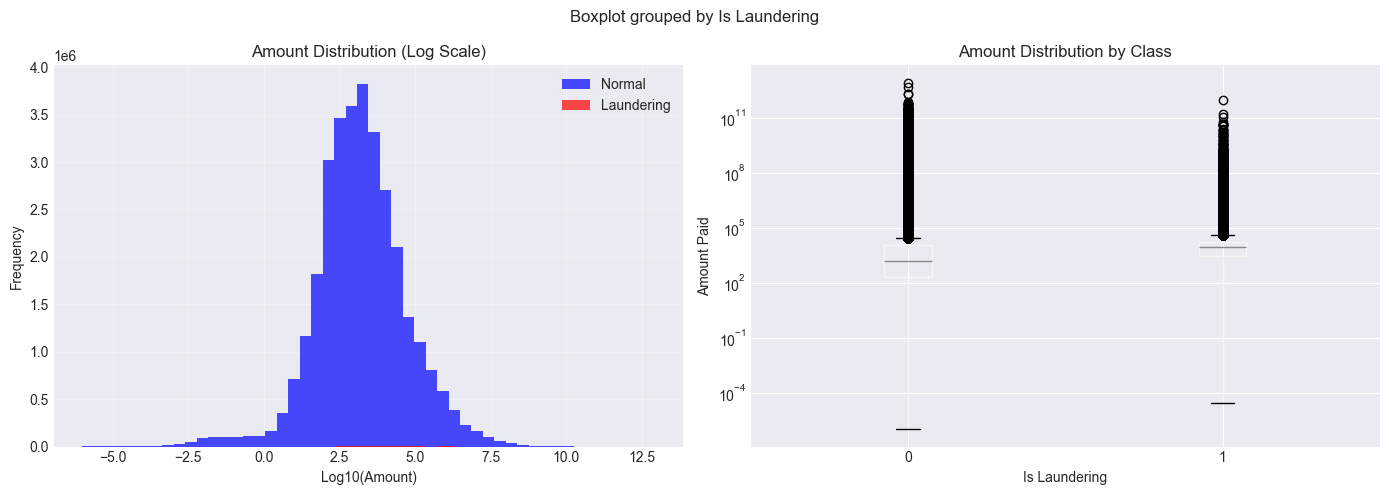

In [33]:
# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Log scale 
normal_amounts = df[df['Is Laundering']==0]['Amount Paid'].apply(lambda x: np.log10(x) if x > 0 else 0)
laundering_amounts = df[df['Is Laundering']==1]['Amount Paid'].apply(lambda x: np.log10(x) if x > 0 else 0)

ax[0].hist(normal_amounts, bins=50, alpha=0.7, label='Normal', color='blue')
ax[0].hist(laundering_amounts, bins=50, alpha=0.7, label='Laundering', color='red')
ax[0].set_xlabel('Log10(Amount)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Amount Distribution (Log Scale)')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Box plot
df.boxplot(column='Amount Paid', by='Is Laundering', ax=ax[1])
ax[1].set_xlabel('Is Laundering')
ax[1].set_ylabel('Amount Paid')
ax[1].set_title('Amount Distribution by Class')
ax[1].set_yscale('log')

plt.tight_layout()
plt.show()

Structuring Detection

In [34]:
#  thresholds by currency
thresholds = {
    'US Dollar': 10000,
    'Euro': 10000,
    'UK Pound': 10000,
    'Canadian Dollar': 10000,
    'Australian Dollar': 10000
}

structuring_results = []

for currency, threshold in thresholds.items():
    currency_df = df[df['Payment Currency'] == currency].copy()
    
    #  threshold (90-99% of threshold)
    below_threshold = currency_df[
        (currency_df['Amount Paid'] >= threshold * 0.90) & 
        (currency_df['Amount Paid'] < threshold)
    ]
    
    # Above threshold
    above_threshold = currency_df[currency_df['Amount Paid'] >= threshold]
    
    structuring_results.append({
        'Currency': currency,
        'Threshold': threshold,
        'Below_Count': len(below_threshold),
        'Below_Laundering_Rate': below_threshold['Is Laundering'].mean() * 100,
        'Above_Count': len(above_threshold),
        'Above_Laundering_Rate': above_threshold['Is Laundering'].mean() * 100
    })



In [35]:
structuring_df = pd.DataFrame(structuring_results)
structuring_df

,Currency,Threshold,Below_Count,Below_Laundering_Rate,Above_Count,Above_Laundering_Rate
0,US Dollar,10000,106692,0.5005,2134945,0.2533
1,Euro,10000,66380,0.5679,1224851,0.2635
2,UK Pound,10000,9117,0.9104,161795,0.2763
3,Canadian Dollar,10000,10111,0.0791,217017,0.0733
4,Australian Dollar,10000,8968,0.1673,194534,0.1450


Round Amount Analysis

In [36]:
df['is_round_1000'] = (df['Amount Paid'] % 1000 == 0).astype(int)
df['is_round_100'] = (df['Amount Paid'] % 100 == 0).astype(int)

round_analysis = pd.DataFrame({
    'Category': ['Round to 1000', 'Round to 100', 'Not Round'],
    'Count': [
        df['is_round_1000'].sum(),
        df[df['is_round_1000']==0]['is_round_100'].sum(),
        len(df) - df['is_round_100'].sum()
    ],
    'Laundering_Rate': [
        df[df['is_round_1000']==1]['Is Laundering'].mean() * 100,
        df[(df['is_round_1000']==0) & (df['is_round_100']==1)]['Is Laundering'].mean() * 100,
        df[df['is_round_100']==0]['Is Laundering'].mean() * 100
    ]
})

round_analysis

,Category,Count,Laundering_Rate
0,Round to 1000,1881,0.1063
1,Round to 100,12551,0.1434
2,Not Round,31883786,0.1104


In [37]:
# Sender account frequency
sender_freq = df.groupby('Account').agg({
    'Is Laundering': ['sum', 'count', 'mean'],
    'Amount Paid': 'sum'
}).round(4)

sender_freq.columns = ['Laundering_Count', 'Txn_Count', 'Laundering_Rate', 'Total_Amount']
sender_freq = sender_freq.sort_values('Txn_Count', ascending=False)

print("Top 20 High-Frequency Sender Accounts")
sender_freq.head(20)

Top 20 High-Frequency Sender Accounts


,Laundering_Count,Txn_Count,Laundering_Rate,Total_Amount
Account,,,,
100428660,1524,1076979,0.0014,318238294016.0000
1004286A8,955,678929,0.0014,153807372288.0000
1004286F0,280,208695,0.0013,428904382464.0000
1004289C0,193,132783,0.0015,114531622912.0000
100428858,164,102358,0.0016,36874534912.0000
100428810,133,96007,0.0014,20818034688.0000
1004287C8,139,90963,0.0015,1654620422144.0000
1004288A0,126,87870,0.0014,43406422016.0000
100428738,100,80578,0.0012,3086870904832.0000


Correlation metrix

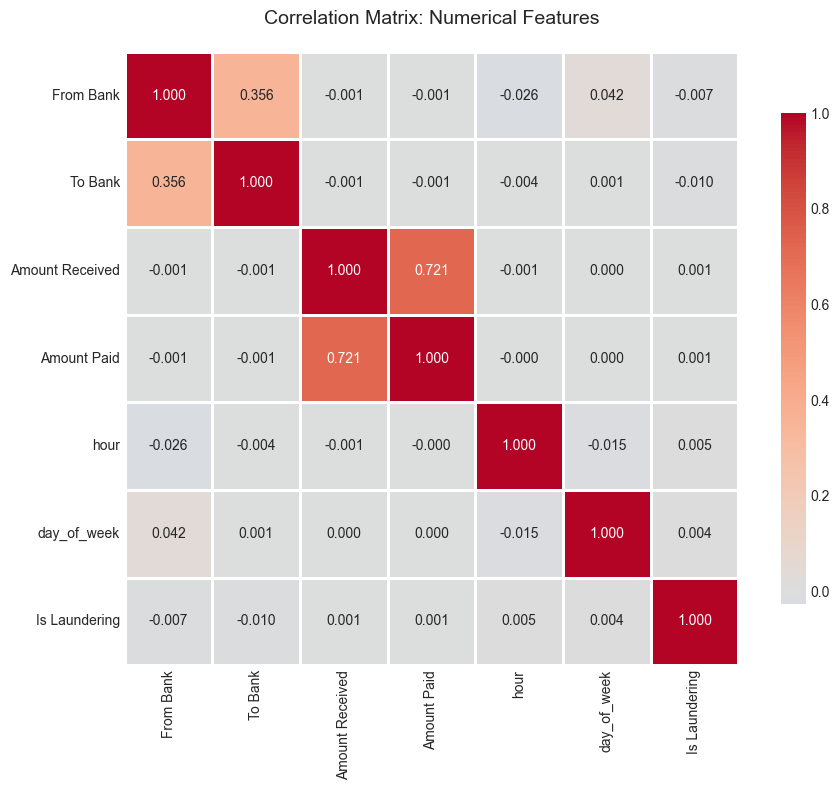

In [38]:
correlation_matrix = df[numerical_features + ['Is Laundering']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Numerical Features', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [39]:

print("\nCorrelation with Target (Is Laundering):")
target_corr = correlation_matrix['Is Laundering'].drop('Is Laundering').sort_values(ascending=False)
target_corr


Correlation with Target (Is Laundering):


hour               0.0046
day_of_week        0.0041
Amount Paid        0.0009
Amount Received    0.0006
From Bank         -0.0072
To Bank           -0.0102
Name: Is Laundering, dtype: float64

In [40]:
if abs(target_corr).max() < 0.1:
    print("  Low correlation with target - Feature engineering needed")
else:
    print(f"  Strongest predictor: {target_corr.abs().idxmax()} (r = {target_corr.abs().max():.4f})")

  Low correlation with target - Feature engineering needed


 EDA results

In [42]:

list(df.columns)

['Timestamp',
 'From Bank',
 'Account',
 'To Bank',
 'Account.1',
 'Amount Received',
 'Receiving Currency',
 'Amount Paid',
 'Payment Currency',
 'Payment Format',
 'Is Laundering',
 'hour',
 'day_of_week',
 'date',
 'is_weekend',
 'is_night',
 'is_cross_currency',
 'is_round_1000',
 'is_round_100']

In [43]:
# Save EDA results
df.to_parquet('../data/Silver/eda_enriched.parquet', index=False, compression='snappy')
print("EDA data saved Complete")

EDA data saved Complete
